In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
import csv
import numpy as np
import h5py
#I use this command to get the current working directory (cwd) so that I can easily refer to this path when writing file paths
cwd = os.getcwd()+'/'

#to add the getrho module, we need to tell python to look in that directory. the folder should be cwd+getrho/
import sys
getrhodir=cwd+'getrho/'
if getrhodir not in sys.path:
    sys.path.append(getrhodir)
import get_rho_p as grp
import get_rho_c as grc
import datetime

from scipy.fft import fftn, ifftn

In [2]:
def rhokoverkm2(rhok):
    nx=rhok.shape[0]
    ny=rhok.shape[1]
    nz=rhok.shape[2]
    rhokk2=np.copy(rhok)
    k2s=np.zeros((nx,ny,nz))
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if i<nx/2:
                    ni=i
                else:
                    ni=i-nx
                if j<ny/2:
                    nj=j
                else:
                    nj=j-nz
                if k<nz/2:
                    nk=k
                else:
                    nk=k-nz
                k2 = 4*(np.pi)**2 *((ni/nx)**2+(nj/ny)**2+(nk/nz)**2)
                k2s[i,j,k]=k2
                if i==0 and j==0 and k==0:
                    rhokk2[i,j,k] = 0
                else:
                    rhokk2[i,j,k]= rhok[i,j,k]/(-k2)
    return rhokk2

def rhokoverlambda(rhok,dx,dy,dz):
    nx=rhok.shape[0]
    ny=rhok.shape[1]
    nz=rhok.shape[2]
    Lx = dx*nx
    Ly = dy*ny
    Lz = dz*nz
    rhokl=np.copy(rhok)
    k2s=np.zeros((nx,ny,nz))
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if i<nx/2:
                    ni=i
                else:
                    ni=i-nx
                if j<ny/2:
                    nj=j
                else:
                    nj=j-nz
                if k<nz/2:
                    nk=k
                else:
                    nk=k-nz
                lambdax = - 4* nx**2 / (Lx**2) * (np.sin(np.pi*ni/nx))**2
                lambday = - 4* ny**2 / (Ly**2) * (np.sin(np.pi*nj/ny))**2
                lambdaz = - 4* nz**2 / (Lz**2) * (np.sin(np.pi*nk/nz))**2
                if i==0 and j==0 and k==0:
                    rhokl[i,j,k] = 0
                else:
                    rhokl[i,j,k]= rhok[i,j,k]/(lambdax+lambday+lambdaz)
    return rhokl

def Fgk2(rho,redz,posx,posy,posz,dx,dy,dz):
    rhok = ifftn(rho*4.78e-10*(1+redz)**3)
    phix = fftn(rhokoverkm2(rhok))
    dphidx = 4*np.pi*(phix[posx+1,posy,posz]-phix[posx-1,posy,posz])/(2*dx)
    dphidy = 4*np.pi*(phix[posx,posy+1,posz]-phix[posx,posy-1,posz])/(2*dy)
    dphidz = 4*np.pi*(phix[posx,posy,posz+1]-phix[posx,posy,posz-1])/(2*dz)
    return np.asarray([-dphidx,-dphidy,-dphidz])

def Fg(rho,redz,posx,posy,posz,dx,dy,dz):
    rhok = ifftn(rho*4.78e-10*(1+redz)**3)
    phix = fftn(rhokoverlambda(rhok,dx,dy,dz))
    dphidx = 4*np.pi*(phix[posx+1,posy,posz]-phix[posx-1,posy,posz])/(2*dx)
    dphidy = 4*np.pi*(phix[posx,posy+1,posz]-phix[posx,posy-1,posz])/(2*dy)
    dphidz = 4*np.pi*(phix[posx,posy,posz+1]-phix[posx,posy,posz-1])/(2*dz)
    return np.asarray([-dphidx,-dphidy,-dphidz])

def rhok_of_rho(rho,redz):
    return ifftn(rho*4.78e-10*(1+redz)**3)

def Fg_of_rhok(rhok,posx,posy,posz,dx,dy,dz):
    phix = fftn(rhokoverlambda(rhok,dx,dy,dz))
    dphidx = 4*np.pi*(phix[posx+1,posy,posz]-phix[posx-1,posy,posz])/(2*dx)
    dphidy = 4*np.pi*(phix[posx,posy+1,posz]-phix[posx,posy-1,posz])/(2*dy)
    dphidz = 4*np.pi*(phix[posx,posy,posz+1]-phix[posx,posy,posz-1])/(2*dz)
    return np.asarray([-dphidx,-dphidy,-dphidz])

def timestep(dt,pos,vel,redz,H,fnet):
    a=1/(1+redz)
    vel2 = vel - 2*H*vel*dt + dt/a*fnet
    pos2 = pos + dt*vel
    return pos2,vel2

def posind(pos,pmin,pmax,bins):
    brange=(pmax-pmin)/bins
    pind=int(np.floor((pos-pmin)/brange))
    return pind

In [3]:
import scipy.integrate as integrate
from scipy import interpolate
from scipy.optimize import fsolve


def time_Hubble_of_a(a_eval):
    def fried(y,t,H0,Om,OL):
        a = y
        dadt = a*H0*np.sqrt(Om/a**3+OL)
        return dadt
    a0=0.0078125
    H0=0.0003333
    Om=0.25
    OL=0.75
    t=np.linspace(0,1.1*H0**(-1),1000)
    sol = integrate.odeint(fried, a0, t, args=(H0,Om,OL))
    f = interpolate.interp1d(t, sol[:,0])
    func = lambda tau : f(tau)-a_eval
    t_eval=fsolve(func,H0**(-1)*a_eval)[0]
    H_eval=(f(t_eval+0.001)-f(t_eval))/(0.001)/a_eval
    return t_eval, H_eval

def a_Hubble_of_t(t_eval):
    def fried(y,t,H0,Om,OL):
        a = y
        dadt = a*H0*np.sqrt(Om/a**3+OL)
        return dadt
    a0=0.0078125
    H0=0.0003333
    Om=0.25
    OL=0.75
    t=np.linspace(0,1.1*H0**(-1),1000)
    sol = integrate.odeint(fried, a0, t, args=(H0,Om,OL))
    f = interpolate.interp1d(t, sol[:,0])
    a_eval = float(f(t_eval))
    H_eval=(f(t_eval+0.001)-f(t_eval))/(0.001)/a_eval
    return a_eval,H_eval
    

In [4]:
#typical? rocket force
time1=datetime.datetime.now()
#t, a, H array
taH=np.zeros((101,3))
tend,Hend=time_Hubble_of_a(1.0)
N=100
for i in range(101):
    taH[i,0]=(tend+1)**(i/N)-1
    taH[i,1],taH[i,2]=a_Hubble_of_t(taH[i,0])
    
#set up rocket force
xi=80
GpoG=0.1
H0=0.00033333
nrocket=np.asarray([1.,0.,0.])
fRocket=H0/xi*GpoG*nrocket
#fRocket = nrocket*5e-7

#initial conditions
a_ini = taH[0,1]
t_ini = taH[0,0]
pos_ini = np.asarray([[35.,35.,35.],[40.,40.,40.],[45.,45.,45.],[55.,55.,55.],[60.,60.,60.]])
vel_ini = np.asarray([[1.,1.,1.],[1.,1.,1.],[1.,1.,1.],[1.,1.,1.],[1.,1.,1.]])/(np.sqrt(3))*2.6/a_ini*np.sqrt(xi*1e-11)*0.3
#pos_ini = np.asarray([25.,25.,25.])
#vel_ini = np.asarray([1.,1.,1.])*6e-4/a_ini

#read info for simulation
path=cwd+'Sim_100v/'
snaps,slnums,sl=grp.get_snapshot_info(path)
bchoice=100
xmin=0
xmax=100
ymin=0
ymax=100
zmin=0
zmax=100
dx=(xmax-xmin)/bchoice
dy=(ymax-ymin)/bchoice
dz=(zmax-zmin)/bchoice

#set up pos, vel arrays to be stored
pos_arr3=np.zeros((len(pos_ini),len(taH),3))
vel_arr3=np.zeros((len(pos_ini),len(taH),3))
for i in range(len(pos_arr3)):
    pos_arr3[i,0]=pos_ini[i]
    vel_arr3[i,0]=vel_ini[i]

time2=datetime.datetime.now()
print('Setting up took '+str((time2-time1).total_seconds())+' seconds.')
time3=datetime.datetime.now()
#loop through time
for i in range(len(taH)-1):
#for i in range(1):
    time4=datetime.datetime.now()
    #get density, redshift from snapshot
    rho,xc,yc,zc=grp.rho_of_snap_P1(path,slnums,snaps[i],xmin,xmax,ymin,ymax,zmin,zmax,bchoice)
    redz,time=grp.get_z_t(path,snaps[i])
    rhok = ifftn(rho*4.78e-10*(1+redz)**3)
    for j in range(len(pos_arr3)):
        posx=posind(pos_arr3[j,i,0],xmin,xmax,bchoice)
        posy=posind(pos_arr3[j,i,1],ymin,ymax,bchoice)
        posz=posind(pos_arr3[j,i,2],zmin,zmax,bchoice)
        if posx<0 or posy<0 or posz<0 or posx>=bchoice or posy>=bchoice or posz>=bchoice:
            print("rocket flew off the grid, ending computation at time index "+str(i)+'. Corresponds to time='+str(taH[i,0])+', a='+str(taH[i,1])+'.')
            print("position indices found to be"+str((posx,posy,posz)))
            break
        fGrav=Fg_of_rhok(rhok,posx,posy,posz,dx,dy,dz)
        fNet=fGrav+fRocket
        dt=taH[i+1,0]-taH[i,0]
        H=taH[i,2]
        pos_arr3[j,i+1],vel_arr3[j,i+1]=timestep(dt,pos_arr3[j,i],vel_arr3[j,i],redz,H,fNet)
    time5=datetime.datetime.now()
    print('Loop element '+str(i)+' took '+str((time5-time4).total_seconds())+' seconds.')
print('Whole loop took '+str((time5-time3).total_seconds()/60.)+' minutes.')
print('Whole process took '+str((time5-time1).total_seconds()/60.)+' minutes.')

Setting up took 0.22378 seconds.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


Loop element 0 took 46.50069 seconds.
Loop element 1 took 40.605585 seconds.
Loop element 2 took 38.773788 seconds.
Loop element 3 took 35.270375 seconds.
Loop element 4 took 31.394 seconds.
Loop element 5 took 30.665914 seconds.
Loop element 6 took 32.792825 seconds.
Loop element 7 took 33.476154 seconds.
Loop element 8 took 34.236233 seconds.
Loop element 9 took 35.335331 seconds.
Loop element 10 took 35.757115 seconds.
Loop element 11 took 34.914065 seconds.
Loop element 12 took 35.838221 seconds.
Loop element 13 took 34.309722 seconds.
Loop element 14 took 32.82997 seconds.
Loop element 15 took 31.815133 seconds.
Loop element 16 took 34.622019 seconds.
Loop element 17 took 33.800143 seconds.
Loop element 18 took 39.422779 seconds.
Loop element 19 took 43.136242 seconds.
Loop element 20 took 33.443458 seconds.
Loop element 21 took 35.232824 seconds.
Loop element 22 took 35.940271 seconds.
Loop element 23 took 34.270039 seconds.
Loop element 24 took 33.655659 seconds.
Loop element 25

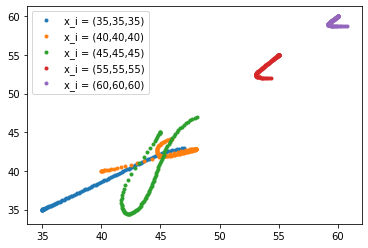

In [5]:
plt.plot(pos_arr3[0,:,0],pos_arr3[0,:,1],'.',label='x_i = (35,35,35)')
plt.plot(pos_arr3[1,:,0],pos_arr3[1,:,1],'.',label='x_i = (40,40,40)')
plt.plot(pos_arr3[2,:,0],pos_arr3[2,:,1],'.',label='x_i = (45,45,45)')
#plt.plot(pos_arr2[1,:,0],pos_arr2[1,:,1],'.',label='x_i = (50,50,50)')
plt.plot(pos_arr3[3,:,0],pos_arr3[3,:,1],'.',label='x_i = (55,55,55)')
plt.plot(pos_arr3[4,:,0],pos_arr3[4,:,1],'.',label='x_i = (60,60,60)')
plt.legend()

In [4]:
f=cwd+'Sim_100v/groups_100/fof_subhalo_tab_100.0.hdf5'
file=h5py.File(f,'r')

In [27]:
file['Header'].attrs['Redshift']

127.0

In [29]:
file['Header'].attrs['Redshift']

124.59683073337136

In [31]:
file['Header'].attrs['Redshift']

121.6562180187796

In [38]:
file['Header'].attrs['Redshift']

11.438311518216711

In [37]:
f=cwd+'Sim_100v/snapdir_056/snapshot_056.0.hdf5'
file=h5py.File(f,'r')

In [12]:
file.keys()

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

In [18]:
file['Group'].keys()

<KeysViewHDF5 ['GroupAscale', 'GroupFirstSub', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupOffsetType', 'GroupPos', 'GroupVel', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']>

In [20]:
file['Group']['Group_R_Crit200'][:]

array([0.17783348], dtype=float32)

In [21]:
file['Group']['Group_M_Crit200'][:]

array([130.7333], dtype=float32)

In [22]:
file['Group']['GroupPos'][:]

array([[50.30435 , 50.334766, 50.52013 ]], dtype=float32)

In [11]:
file['Header'].attrs.keys()

<KeysViewHDF5 ['BoxSize', 'Git_commit', 'Git_date', 'Ngroups_ThisFile', 'Ngroups_Total', 'Nids_ThisFile', 'Nids_Total', 'Nsubhalos_ThisFile', 'Nsubhalos_Total', 'NumFiles', 'Redshift', 'Time']>

In [21]:
testarr=np.zeros(15)
testarr[0:10]=[0,1,2,3,4,5,6,7,8,9]
testarr

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 0., 0., 0., 0.])

In [13]:
file['Header'].attrs['NumPart_ThisFile']

array([     0, 307859,  12529, 123124,      0,      0], dtype=uint32)

In [16]:
file['Header'].attrs['NumPart_Total'][1]

3055679

In [6]:
path=cwd+'Sim_100v/'
snaps,slnums,sl=grp.get_snapshot_info(path)

In [3]:
t1=datetime.datetime.now()
p1,m1=grp.get_particles_type(path,slnums,snaps[0],ptypes=['PartType1'])
t2=datetime.datetime.now()
print('took '+str((t2-t1).total_seconds())+' seconds.')

took 2.670383 seconds.


In [7]:
t1=datetime.datetime.now()
p2,m2=grp.get_particles_type2(path,slnums,snaps[0],ptypes=['PartType1'])
t2=datetime.datetime.now()
print('took '+str((t2-t1).total_seconds())+' seconds.')

took 0.301874 seconds.


In [9]:
m2

{'mP1': array([0.00018764, 0.00018764, 0.00018764, ..., 0.00018764, 0.00018764,
        0.00018764])}

In [16]:
t1=datetime.datetime.now()
rho,xc,yc,zc=grc.fastest_getrhoxyz_minmax(p2['xP1'],p2['yP1'],p2['zP1'],m2['mP1'],100,0,100,0,100,0,100)
t2=datetime.datetime.now()
print('took '+str((t2-t1).total_seconds())+' seconds.')

took 0.238787 seconds.


In [17]:
t1=datetime.datetime.now()
rho2,xc2,yc2,zc2=grc.getrhoxyz_minmax_p_m(p2['xP1'],p2['yP1'],p2['zP1'],m2['mP1'],100,0,100,0,100,0,100)
t2=datetime.datetime.now()
print('took '+str((t2-t1).total_seconds())+' seconds.')

took 0.097119 seconds.


In [4]:
file.keys()

<KeysViewHDF5 ['Config', 'Header', 'Parameters', 'PartType1', 'PartType2', 'PartType3']>

In [14]:
file['PartType1']['Coordinates'][:,0]

(307859,)

In [ ]:
2+2

In [13]:
fGrav

array([1.08238158e-09-3.15533138e-25j, 3.30052663e-09-5.81766093e-25j,
       2.08140959e-09+1.51184677e-25j])

In [23]:
#try one
time1=datetime.datetime.now()
#t, a, H array
taH=np.zeros((101,3))
tend,Hend=time_Hubble_of_a(1.0)
N=100
for i in range(101):
    taH[i,0]=(tend+1)**(i/N)-1
    taH[i,1],taH[i,2]=a_Hubble_of_t(taH[i,0])
    
#set up rocket force
xi=50
GpoG=0.1
H0=0.00033333
nrocket=np.asarray([1.,0.,0.])
fRocket=H0/xi*GpoG*nrocket
#fRocket = nrocket*5e-7

Gmu=1e-11
#initial conditions
a_ini = taH[0,1]
t_ini = taH[0,0]
pos_ini = np.asarray([[45.,45.,45.]])
vel_ini = np.asarray([[1.,1.,1.]])/(np.sqrt(3))*2.6/a_ini*np.sqrt(xi*1e-11)*0.3
#vel_ini = np.asarray([[1.,1.,1.]])*6e-4/a_ini
#pos_ini = np.asarray([25.,25.,25.])
#vel_ini = np.asarray([1.,1.,1.])*6e-4/a_ini

#read info for simulation
path=cwd+'Sim_100v/'
snaps,slnums,sl=grp.get_snapshot_info(path)
bchoice=100
xmin=0
xmax=100
ymin=0
ymax=100
zmin=0
zmax=100
dx=(xmax-xmin)/bchoice
dy=(ymax-ymin)/bchoice
dz=(zmax-zmin)/bchoice

#set up pos, vel arrays to be stored
pos_arr0=np.zeros((len(pos_ini),len(taH),3))
vel_arr0=np.zeros((len(pos_ini),len(taH),3))
for i in range(len(pos_arr0)):
    pos_arr0[i,0]=pos_ini[i]
    vel_arr0[i,0]=vel_ini[i]

time2=datetime.datetime.now()
print('Setting up took '+str((time2-time1).total_seconds())+' seconds.')
time3=datetime.datetime.now()
#loop through time
for i in range(len(taH)-1):
#for i in range(1):
    time4=datetime.datetime.now()
    #get density, redshift from snapshot
    rho,xc,yc,zc=grp.rho_of_snap_P1(path,slnums,snaps[i],xmin,xmax,ymin,ymax,zmin,zmax,bchoice)
    redz,time=grp.get_z_t(path,snaps[i])
    for j in range(len(pos_arr0)):
        posx=posind(pos_arr0[j,i,0],xmin,xmax,bchoice)
        posy=posind(pos_arr0[j,i,1],ymin,ymax,bchoice)
        posz=posind(pos_arr0[j,i,2],zmin,zmax,bchoice)
        if posx<0 or posy<0 or posz<0 or posx>=bchoice or posy>=bchoice or posz>=bchoice:
            print("rocket flew off the grid, ending computation at time index "+str(i)+'. Corresponds to time='+str(taH[i,0])+', a='+str(taH[i,1])+'.')
            print("position indices found to be"+str((posx,posy,posz)))
            break
        fGrav=Fg(rho,redz,posx,posy,posz,dx,dy,dz)
        fNet=fGrav+fRocket
        dt=taH[i+1,0]-taH[i,0]
        H=taH[i,2]
        pos_arr0[j,i+1],vel_arr0[j,i+1]=timestep(dt,pos_arr0[j,i],vel_arr0[j,i],redz,H,fNet)
    time5=datetime.datetime.now()
    print('Loop element '+str(i)+' took '+str((time5-time4).total_seconds())+' seconds.')
print('Whole loop took '+str((time5-time3).total_seconds()/60.)+' minutes.')
print('Whole process took '+str((time5-time1).total_seconds()/60.)+' minutes.')

Setting up took 0.587072 seconds.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:72: ComplexWarning: Casting complex values to real discards the imaginary part


Loop element 0 took 19.862604 seconds.
Loop element 1 took 21.617053 seconds.
Loop element 2 took 23.197088 seconds.
Loop element 3 took 27.310045 seconds.
Loop element 4 took 29.027238 seconds.
Loop element 5 took 28.814915 seconds.
Loop element 6 took 28.471176 seconds.
Loop element 7 took 28.858568 seconds.
Loop element 8 took 20.298548 seconds.
Loop element 9 took 16.096899 seconds.
Loop element 10 took 26.585728 seconds.
Loop element 11 took 29.621243 seconds.
Loop element 12 took 25.792167 seconds.
Loop element 13 took 27.610913 seconds.
Loop element 14 took 26.228641 seconds.
Loop element 15 took 17.710345 seconds.
Loop element 16 took 16.758545 seconds.
Loop element 17 took 14.508844 seconds.
Loop element 18 took 17.150744 seconds.
Loop element 19 took 23.946129 seconds.
Loop element 20 took 19.512791 seconds.
Loop element 21 took 19.824981 seconds.
Loop element 22 took 27.296769 seconds.
Loop element 23 took 16.062935 seconds.
Loop element 24 took 17.571652 seconds.
Loop eleme

KeyboardInterrupt: 

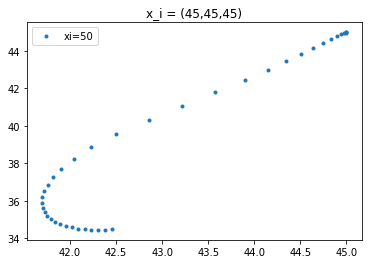

In [53]:
plt.plot(pos_arr0[0,:39,0],pos_arr0[0,:39,1],'.',label='xi=50')
plt.title('x_i = (45,45,45)')
plt.legend()

In [52]:
taH[39,1]**(-1)-1

28.821137520052076

In [39]:
fGrav

array([2.00061857e-06-4.31324794e-22j, 1.43035692e-05+3.60104266e-21j,
       5.30713392e-06-2.09679745e-22j])

In [54]:
fRocket

array([6.6666e-07, 0.0000e+00, 0.0000e+00])

In [5]:
#try one
time1=datetime.datetime.now()
#t, a, H array
taH=np.zeros((101,3))
tend,Hend=time_Hubble_of_a(1.0)
N=100
for i in range(101):
    taH[i,0]=(tend+1)**(i/N)-1
    taH[i,1],taH[i,2]=a_Hubble_of_t(taH[i,0])
    
#set up rocket force
xi=50
GpoG=0.1
H0=0.00033333
nrocket=np.asarray([1.,0.,0.])
fRocket=H0/xi*GpoG*nrocket
#fRocket = nrocket*5e-7

#initial conditions
a_ini = taH[0,1]
t_ini = taH[0,0]
pos_ini = np.asarray([[45.,45.,45.]])
vel_ini = np.asarray([[1.,1.,1.]])*6e-4/a_ini
#pos_ini = np.asarray([25.,25.,25.])
#vel_ini = np.asarray([1.,1.,1.])*6e-4/a_ini

#read info for simulation
path=cwd+'Sim_100v/'
snaps,slnums,sl=grp.get_snapshot_info(path)
bchoice=100
xmin=0
xmax=100
ymin=0
ymax=100
zmin=0
zmax=100
dx=(xmax-xmin)/bchoice
dy=(ymax-ymin)/bchoice
dz=(zmax-zmin)/bchoice

#set up pos, vel arrays to be stored
pos_arr01=np.zeros((len(pos_ini),len(taH),3))
vel_arr01=np.zeros((len(pos_ini),len(taH),3))
for i in range(len(pos_arr01)):
    pos_arr01[i,0]=pos_ini[i]
    vel_arr01[i,0]=vel_ini[i]

time2=datetime.datetime.now()
print('Setting up took '+str((time2-time1).total_seconds())+' seconds.')
time3=datetime.datetime.now()
#loop through time
for i in range(len(taH)-1):
#for i in range(1):
    time4=datetime.datetime.now()
    #get density, redshift from snapshot
    rho,xc,yc,zc=grp.rho_of_snap_P1(path,slnums,snaps[i],xmin,xmax,ymin,ymax,zmin,zmax,bchoice)
    redz,time=grp.get_z_t(path,snaps[i])
    #rhok=
    for j in range(len(pos_arr01)):
        posx=posind(pos_arr01[j,i,0],xmin,xmax,bchoice)
        posy=posind(pos_arr01[j,i,1],ymin,ymax,bchoice)
        posz=posind(pos_arr01[j,i,2],zmin,zmax,bchoice)
        if posx<0 or posy<0 or posz<0 or posx>=bchoice or posy>=bchoice or posz>=bchoice:
            print("rocket flew off the grid, ending computation at time index "+str(i)+'. Corresponds to time='+str(taH[i,0])+', a='+str(taH[i,1])+'.')
            print("position indices found to be"+str((posx,posy,posz)))
            break
        fGrav=Fg(rho,redz,posx,posy,posz,dx,dy,dz)
        fNet=fGrav+fRocket
        dt=taH[i+1,0]-taH[i,0]
        H=taH[i,2]
        pos_arr01[j,i+1],vel_arr01[j,i+1]=timestep(dt,pos_arr01[j,i],vel_arr01[j,i],redz,H,fNet)
    time5=datetime.datetime.now()
    print('Loop element '+str(i)+' took '+str((time5-time4).total_seconds())+' seconds.')
print('Whole loop took '+str((time5-time3).total_seconds()/60.)+' minutes.')
print('Whole process took '+str((time5-time1).total_seconds()/60.)+' minutes.')

Setting up took 0.193955 seconds.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:70: ComplexWarning: Casting complex values to real discards the imaginary part


Loop element 0 took 6.643949 seconds.
Loop element 1 took 6.342881 seconds.
Loop element 2 took 6.169716 seconds.
Loop element 3 took 6.560397 seconds.
Loop element 4 took 6.593486 seconds.
Loop element 5 took 6.691354 seconds.
Loop element 6 took 6.51279 seconds.
Loop element 7 took 6.53009 seconds.
Loop element 8 took 6.725873 seconds.
Loop element 9 took 6.349008 seconds.
Loop element 10 took 6.415015 seconds.
Loop element 11 took 6.302271 seconds.
Loop element 12 took 6.777824 seconds.
Loop element 13 took 9.593981 seconds.
Loop element 14 took 15.104798 seconds.
Loop element 15 took 16.897677 seconds.
Loop element 16 took 14.754191 seconds.
Loop element 17 took 19.124962 seconds.
Loop element 18 took 28.314643 seconds.
Loop element 19 took 22.282789 seconds.
Loop element 20 took 24.936707 seconds.
Loop element 21 took 20.794075 seconds.
Loop element 22 took 19.816464 seconds.
Loop element 23 took 26.62242 seconds.
Loop element 24 took 31.78557 seconds.
Loop element 25 took 29.3119

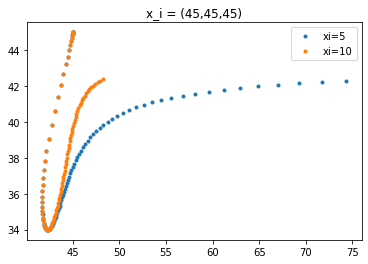

In [7]:
plt.plot(pos_arr0[0,:,0],pos_arr0[0,:,1],'.',label='xi=5')
plt.plot(pos_arr01[0,:,0],pos_arr01[0,:,1],'.',label='xi=10')
plt.title('x_i = (45,45,45)')
plt.legend()

In [4]:
xi=5
GpoG=0.1
H0=0.00033333
nrocket=np.asarray([1.,0.,0.])
fRocket=H0/xi*GpoG*nrocket
fRocket

array([6.6666e-06, 0.0000e+00, 0.0000e+00])

In [6]:
np.zeros((3,2,3))

array([[[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]])

In [5]:
#turn off rocket, sanity check
time1=datetime.datetime.now()
#t, a, H array
taH=np.zeros((101,3))
tend,Hend=time_Hubble_of_a(1.0)
N=100
for i in range(101):
    taH[i,0]=(tend+1)**(i/N)-1
    taH[i,1],taH[i,2]=a_Hubble_of_t(taH[i,0])
    
#set up rocket force
xi=5
GpoG=0.1
H0=0.00033333
nrocket=np.asarray([1.,0.,0.])
#fRocket=H0/xi*GpoG*nrocket
fRocket = np.asarray([0.0,0.0,0.0])

#initial conditions
a_ini = taH[0,1]
t_ini = taH[0,0]
pos_ini = np.asarray([[25.,25.,25.],[50.,50.,50.],[75.,75.,75.]])
vel_ini = np.asarray([[1.,1.,1.],[1.,1.,1.],[1.,1.,1.]])*6e-4/a_ini
#pos_ini = np.asarray([25.,25.,25.])
#vel_ini = np.asarray([1.,1.,1.])*6e-4/a_ini

#read info for simulation
path=cwd+'Sim_100v/'
snaps,slnums,sl=grp.get_snapshot_info(path)
bchoice=100
xmin=0
xmax=100
ymin=0
ymax=100
zmin=0
zmax=100
dx=(xmax-xmin)/bchoice
dy=(ymax-ymin)/bchoice
dz=(zmax-zmin)/bchoice

#set up pos, vel arrays to be stored
pos_arr=np.zeros((3,len(taH),3))
vel_arr=np.zeros((3,len(taH),3))
for i in range(3):
    pos_arr[i,0]=pos_ini[i]
    vel_arr[i,0]=vel_ini[i]

time2=datetime.datetime.now()
print('Setting up took '+str((time2-time1).total_seconds())+' seconds.')
time3=datetime.datetime.now()
#loop through time
for i in range(len(taH)-1):
#for i in range(1):
    time4=datetime.datetime.now()
    #get density, redshift from snapshot
    rho,xc,yc,zc=grp.rho_of_snap_P1(path,slnums,snaps[i],xmin,xmax,ymin,ymax,zmin,zmax,bchoice)
    redz,time=grp.get_z_t(path,snaps[i])
    for j in range(3):
        posx=posind(pos_arr[j,i,0],xmin,xmax,bchoice)
        posy=posind(pos_arr[j,i,1],ymin,ymax,bchoice)
        posz=posind(pos_arr[j,i,2],zmin,zmax,bchoice)
        if posx<0 or posy<0 or posz<0 or posx>=bchoice or posy>=bchoice or posz>=bchoice:
            print("rocket flew off the grid, ending computation at time index "+str(i)+'. Corresponds to time='+str(taH[i,0])+', a='+str(taH[i,1])+'.')
            print("position indices found to be"+str((posx,posy,posz)))
            break
        fGrav=Fg(rho,redz,posx,posy,posz,dx,dy,dz)
        fNet=fGrav+fRocket
        dt=taH[i+1,0]-taH[i,0]
        H=taH[i,2]
        pos_arr[j,i+1],vel_arr[j,i+1]=timestep(dt,pos_arr[j,i],vel_arr[j,i],redz,H,fNet)
    time5=datetime.datetime.now()
    print('Loop element '+str(i)+' took '+str((time5-time4).total_seconds())+' seconds.')
print('Whole loop took '+str((time5-time3).total_seconds()/60.)+' minutes.')
print('Whole process took '+str((time5-time1).total_seconds()/60.)+' minutes.')

Setting up took 0.205764 seconds.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:70: ComplexWarning: Casting complex values to real discards the imaginary part


Loop element 0 took 19.602586 seconds.
Loop element 1 took 18.80486 seconds.
Loop element 2 took 20.806237 seconds.
Loop element 3 took 23.016257 seconds.
Loop element 4 took 20.966816 seconds.
Loop element 5 took 19.138305 seconds.
Loop element 6 took 18.347445 seconds.
Loop element 7 took 18.56282 seconds.
Loop element 8 took 18.250858 seconds.
Loop element 9 took 19.686318 seconds.
Loop element 10 took 19.198635 seconds.
Loop element 11 took 18.316831 seconds.
Loop element 12 took 18.960264 seconds.
Loop element 13 took 18.63826 seconds.
Loop element 14 took 18.98493 seconds.
Loop element 15 took 18.324543 seconds.
Loop element 16 took 18.343948 seconds.
Loop element 17 took 18.552661 seconds.
Loop element 18 took 18.826895 seconds.
Loop element 19 took 18.50446 seconds.
Loop element 20 took 18.987696 seconds.
Loop element 21 took 18.814149 seconds.
Loop element 22 took 18.627942 seconds.
Loop element 23 took 18.525208 seconds.
Loop element 24 took 18.258434 seconds.
Loop element 25

In [7]:
#small rocket force
time1=datetime.datetime.now()
#t, a, H array
taH=np.zeros((101,3))
tend,Hend=time_Hubble_of_a(1.0)
N=100
for i in range(101):
    taH[i,0]=(tend+1)**(i/N)-1
    taH[i,1],taH[i,2]=a_Hubble_of_t(taH[i,0])
    
#set up rocket force
xi=5
GpoG=0.1
H0=0.00033333
nrocket=np.asarray([1.,0.,0.])
#fRocket=H0/xi*GpoG*nrocket
fRocket = nrocket*5e-7

#initial conditions
a_ini = taH[0,1]
t_ini = taH[0,0]
pos_ini = np.asarray([[25.,25.,25.],[50.,50.,50.],[75.,75.,75.]])
vel_ini = np.asarray([[1.,1.,1.],[1.,1.,1.],[1.,1.,1.]])*6e-4/a_ini
#pos_ini = np.asarray([25.,25.,25.])
#vel_ini = np.asarray([1.,1.,1.])*6e-4/a_ini

#read info for simulation
path=cwd+'Sim_100v/'
snaps,slnums,sl=grp.get_snapshot_info(path)
bchoice=100
xmin=0
xmax=100
ymin=0
ymax=100
zmin=0
zmax=100
dx=(xmax-xmin)/bchoice
dy=(ymax-ymin)/bchoice
dz=(zmax-zmin)/bchoice

#set up pos, vel arrays to be stored
pos_arr2=np.zeros((3,len(taH),3))
vel_arr2=np.zeros((3,len(taH),3))
for i in range(3):
    pos_arr2[i,0]=pos_ini[i]
    vel_arr2[i,0]=vel_ini[i]

time2=datetime.datetime.now()
print('Setting up took '+str((time2-time1).total_seconds())+' seconds.')
time3=datetime.datetime.now()
#loop through time
for i in range(len(taH)-1):
#for i in range(1):
    time4=datetime.datetime.now()
    #get density, redshift from snapshot
    rho,xc,yc,zc=grp.rho_of_snap_P1(path,slnums,snaps[i],xmin,xmax,ymin,ymax,zmin,zmax,bchoice)
    redz,time=grp.get_z_t(path,snaps[i])
    for j in range(3):
        posx=posind(pos_arr2[j,i,0],xmin,xmax,bchoice)
        posy=posind(pos_arr2[j,i,1],ymin,ymax,bchoice)
        posz=posind(pos_arr2[j,i,2],zmin,zmax,bchoice)
        if posx<0 or posy<0 or posz<0 or posx>=bchoice or posy>=bchoice or posz>=bchoice:
            print("rocket flew off the grid, ending computation at time index "+str(i)+'. Corresponds to time='+str(taH[i,0])+', a='+str(taH[i,1])+'.')
            print("position indices found to be"+str((posx,posy,posz)))
            break
        fGrav=Fg(rho,redz,posx,posy,posz,dx,dy,dz)
        fNet=fGrav+fRocket
        dt=taH[i+1,0]-taH[i,0]
        H=taH[i,2]
        pos_arr2[j,i+1],vel_arr2[j,i+1]=timestep(dt,pos_arr2[j,i],vel_arr2[j,i],redz,H,fNet)
    time5=datetime.datetime.now()
    print('Loop element '+str(i)+' took '+str((time5-time4).total_seconds())+' seconds.')
print('Whole loop took '+str((time5-time3).total_seconds()/60.)+' minutes.')
print('Whole process took '+str((time5-time1).total_seconds()/60.)+' minutes.')

Setting up took 0.213635 seconds.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:70: ComplexWarning: Casting complex values to real discards the imaginary part


Loop element 0 took 19.007755 seconds.
Loop element 1 took 19.417905 seconds.
Loop element 2 took 19.962717 seconds.
Loop element 3 took 20.607082 seconds.
Loop element 4 took 18.985448 seconds.
Loop element 5 took 20.141508 seconds.
Loop element 6 took 19.542696 seconds.
Loop element 7 took 20.051802 seconds.
Loop element 8 took 20.119793 seconds.
Loop element 9 took 19.396066 seconds.
Loop element 10 took 20.612985 seconds.
Loop element 11 took 19.975507 seconds.
Loop element 12 took 19.524011 seconds.
Loop element 13 took 19.020267 seconds.
Loop element 14 took 19.565595 seconds.
Loop element 15 took 19.459125 seconds.
Loop element 16 took 19.689433 seconds.
Loop element 17 took 19.561097 seconds.
Loop element 18 took 19.157115 seconds.
Loop element 19 took 19.400193 seconds.
Loop element 20 took 19.066665 seconds.
Loop element 21 took 19.897996 seconds.
Loop element 22 took 19.510163 seconds.
Loop element 23 took 20.083935 seconds.
Loop element 24 took 19.331929 seconds.
Loop eleme

In [10]:
#small rocket force
time1=datetime.datetime.now()
#t, a, H array
taH=np.zeros((101,3))
tend,Hend=time_Hubble_of_a(1.0)
N=100
for i in range(101):
    taH[i,0]=(tend+1)**(i/N)-1
    taH[i,1],taH[i,2]=a_Hubble_of_t(taH[i,0])
    
#set up rocket force
xi=5
GpoG=0.1
H0=0.00033333
nrocket=np.asarray([1.,0.,0.])
#fRocket=H0/xi*GpoG*nrocket
fRocket = nrocket*5e-7

#initial conditions
a_ini = taH[0,1]
t_ini = taH[0,0]
pos_ini = np.asarray([[35.,35.,35.],[40.,40.,40.],[45.,45.,45.],[55.,55.,55.],[60.,60.,60.]])
vel_ini = np.asarray([[1.,1.,1.],[1.,1.,1.],[1.,1.,1.],[1.,1.,1.],[1.,1.,1.]])*6e-4/a_ini
#pos_ini = np.asarray([25.,25.,25.])
#vel_ini = np.asarray([1.,1.,1.])*6e-4/a_ini

#read info for simulation
path=cwd+'Sim_100v/'
snaps,slnums,sl=grp.get_snapshot_info(path)
bchoice=100
xmin=0
xmax=100
ymin=0
ymax=100
zmin=0
zmax=100
dx=(xmax-xmin)/bchoice
dy=(ymax-ymin)/bchoice
dz=(zmax-zmin)/bchoice

#set up pos, vel arrays to be stored
pos_arr3=np.zeros((len(pos_ini),len(taH),3))
vel_arr3=np.zeros((len(pos_ini),len(taH),3))
for i in range(len(pos_arr3)):
    pos_arr3[i,0]=pos_ini[i]
    vel_arr3[i,0]=vel_ini[i]

time2=datetime.datetime.now()
print('Setting up took '+str((time2-time1).total_seconds())+' seconds.')
time3=datetime.datetime.now()
#loop through time
for i in range(len(taH)-1):
#for i in range(1):
    time4=datetime.datetime.now()
    #get density, redshift from snapshot
    rho,xc,yc,zc=grp.rho_of_snap_P1(path,slnums,snaps[i],xmin,xmax,ymin,ymax,zmin,zmax,bchoice)
    redz,time=grp.get_z_t(path,snaps[i])
    for j in range(len(pos_arr3)):
        posx=posind(pos_arr3[j,i,0],xmin,xmax,bchoice)
        posy=posind(pos_arr3[j,i,1],ymin,ymax,bchoice)
        posz=posind(pos_arr3[j,i,2],zmin,zmax,bchoice)
        if posx<0 or posy<0 or posz<0 or posx>=bchoice or posy>=bchoice or posz>=bchoice:
            print("rocket flew off the grid, ending computation at time index "+str(i)+'. Corresponds to time='+str(taH[i,0])+', a='+str(taH[i,1])+'.')
            print("position indices found to be"+str((posx,posy,posz)))
            break
        fGrav=Fg(rho,redz,posx,posy,posz,dx,dy,dz)
        fNet=fGrav+fRocket
        dt=taH[i+1,0]-taH[i,0]
        H=taH[i,2]
        pos_arr3[j,i+1],vel_arr3[j,i+1]=timestep(dt,pos_arr3[j,i],vel_arr3[j,i],redz,H,fNet)
    time5=datetime.datetime.now()
    print('Loop element '+str(i)+' took '+str((time5-time4).total_seconds())+' seconds.')
print('Whole loop took '+str((time5-time3).total_seconds()/60.)+' minutes.')
print('Whole process took '+str((time5-time1).total_seconds()/60.)+' minutes.')

Setting up took 0.22662 seconds.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:70: ComplexWarning: Casting complex values to real discards the imaginary part


Loop element 0 took 33.065933 seconds.
Loop element 1 took 32.090848 seconds.
Loop element 2 took 32.984493 seconds.
Loop element 3 took 33.689862 seconds.
Loop element 4 took 32.129484 seconds.
Loop element 5 took 33.253353 seconds.
Loop element 6 took 33.281884 seconds.
Loop element 7 took 32.471716 seconds.
Loop element 8 took 31.851939 seconds.
Loop element 9 took 31.757574 seconds.
Loop element 10 took 32.154739 seconds.
Loop element 11 took 32.062765 seconds.
Loop element 12 took 32.222664 seconds.
Loop element 13 took 32.81726 seconds.
Loop element 14 took 33.261406 seconds.
Loop element 15 took 31.735175 seconds.
Loop element 16 took 33.693923 seconds.
Loop element 17 took 32.512855 seconds.
Loop element 18 took 32.489473 seconds.
Loop element 19 took 32.108383 seconds.
Loop element 20 took 33.276492 seconds.
Loop element 21 took 32.284596 seconds.
Loop element 22 took 33.273096 seconds.
Loop element 23 took 32.602451 seconds.
Loop element 24 took 32.790993 seconds.
Loop elemen

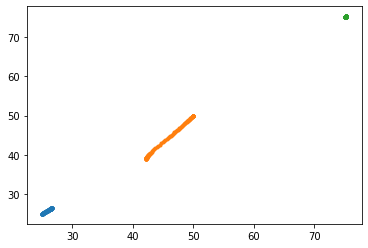

In [6]:
plt.plot(pos_arr[0,:,0],pos_arr[0,:,1],'.')
plt.plot(pos_arr[1,:,0],pos_arr[1,:,1],'.')
plt.plot(pos_arr[2,:,0],pos_arr[2,:,1],'.')

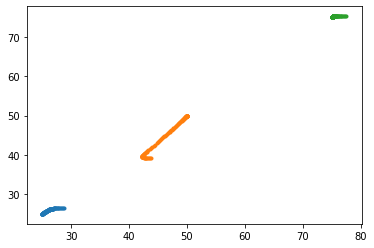

In [8]:
plt.plot(pos_arr2[0,:,0],pos_arr2[0,:,1],'.')
plt.plot(pos_arr2[1,:,0],pos_arr2[1,:,1],'.')
plt.plot(pos_arr2[2,:,0],pos_arr2[2,:,1],'.')

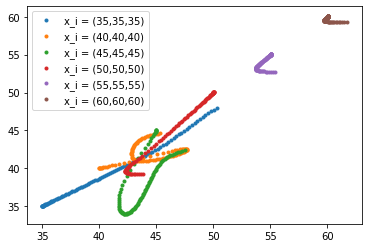

In [16]:
plt.plot(pos_arr3[0,:,0],pos_arr3[0,:,1],'.',label='x_i = (35,35,35)')
plt.plot(pos_arr3[1,:,0],pos_arr3[1,:,1],'.',label='x_i = (40,40,40)')
plt.plot(pos_arr3[2,:,0],pos_arr3[2,:,1],'.',label='x_i = (45,45,45)')
plt.plot(pos_arr2[1,:,0],pos_arr2[1,:,1],'.',label='x_i = (50,50,50)')
plt.plot(pos_arr3[3,:,0],pos_arr3[3,:,1],'.',label='x_i = (55,55,55)')
plt.plot(pos_arr3[4,:,0],pos_arr3[4,:,1],'.',label='x_i = (60,60,60)')
plt.legend()

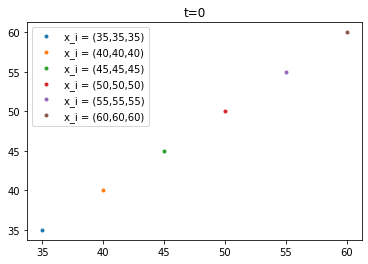

In [17]:
t=0
plt.plot(pos_arr3[0,t,0],pos_arr3[0,t,1],'.',label='x_i = (35,35,35)')
plt.plot(pos_arr3[1,t,0],pos_arr3[1,t,1],'.',label='x_i = (40,40,40)')
plt.plot(pos_arr3[2,t,0],pos_arr3[2,t,1],'.',label='x_i = (45,45,45)')
plt.plot(pos_arr2[1,t,0],pos_arr2[1,t,1],'.',label='x_i = (50,50,50)')
plt.plot(pos_arr3[3,t,0],pos_arr3[3,t,1],'.',label='x_i = (55,55,55)')
plt.plot(pos_arr3[4,t,0],pos_arr3[4,t,1],'.',label='x_i = (60,60,60)')
plt.title('t='+str(t))
plt.legend()

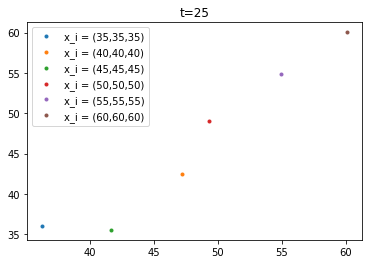

In [19]:
t=int(len(taH)/4)
plt.plot(pos_arr3[0,t,0],pos_arr3[0,t,1],'.',label='x_i = (35,35,35)')
plt.plot(pos_arr3[1,t,0],pos_arr3[1,t,1],'.',label='x_i = (40,40,40)')
plt.plot(pos_arr3[2,t,0],pos_arr3[2,t,1],'.',label='x_i = (45,45,45)')
plt.plot(pos_arr2[1,t,0],pos_arr2[1,t,1],'.',label='x_i = (50,50,50)')
plt.plot(pos_arr3[3,t,0],pos_arr3[3,t,1],'.',label='x_i = (55,55,55)')
plt.plot(pos_arr3[4,t,0],pos_arr3[4,t,1],'.',label='x_i = (60,60,60)')
plt.title('t='+str(t))
plt.legend()

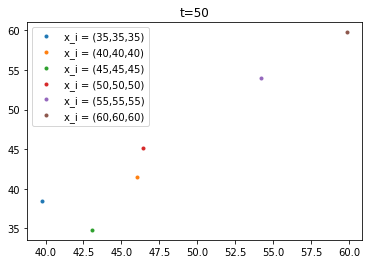

In [20]:
t=int(len(taH)/2)
plt.plot(pos_arr3[0,t,0],pos_arr3[0,t,1],'.',label='x_i = (35,35,35)')
plt.plot(pos_arr3[1,t,0],pos_arr3[1,t,1],'.',label='x_i = (40,40,40)')
plt.plot(pos_arr3[2,t,0],pos_arr3[2,t,1],'.',label='x_i = (45,45,45)')
plt.plot(pos_arr2[1,t,0],pos_arr2[1,t,1],'.',label='x_i = (50,50,50)')
plt.plot(pos_arr3[3,t,0],pos_arr3[3,t,1],'.',label='x_i = (55,55,55)')
plt.plot(pos_arr3[4,t,0],pos_arr3[4,t,1],'.',label='x_i = (60,60,60)')
plt.title('t='+str(t))
plt.legend()

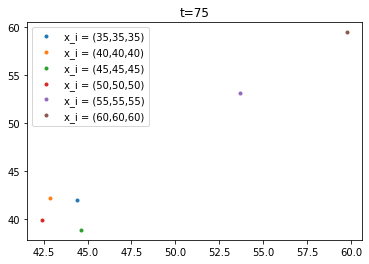

In [21]:
t=int(3*len(taH)/4)
plt.plot(pos_arr3[0,t,0],pos_arr3[0,t,1],'.',label='x_i = (35,35,35)')
plt.plot(pos_arr3[1,t,0],pos_arr3[1,t,1],'.',label='x_i = (40,40,40)')
plt.plot(pos_arr3[2,t,0],pos_arr3[2,t,1],'.',label='x_i = (45,45,45)')
plt.plot(pos_arr2[1,t,0],pos_arr2[1,t,1],'.',label='x_i = (50,50,50)')
plt.plot(pos_arr3[3,t,0],pos_arr3[3,t,1],'.',label='x_i = (55,55,55)')
plt.plot(pos_arr3[4,t,0],pos_arr3[4,t,1],'.',label='x_i = (60,60,60)')
plt.title('t='+str(t))
plt.legend()

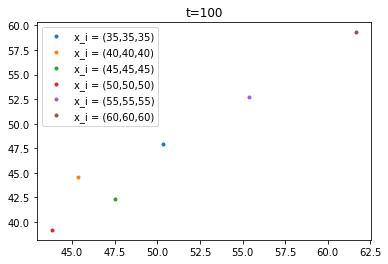

In [23]:
t=int(len(taH))-1
plt.plot(pos_arr3[0,t,0],pos_arr3[0,t,1],'.',label='x_i = (35,35,35)')
plt.plot(pos_arr3[1,t,0],pos_arr3[1,t,1],'.',label='x_i = (40,40,40)')
plt.plot(pos_arr3[2,t,0],pos_arr3[2,t,1],'.',label='x_i = (45,45,45)')
plt.plot(pos_arr2[1,t,0],pos_arr2[1,t,1],'.',label='x_i = (50,50,50)')
plt.plot(pos_arr3[3,t,0],pos_arr3[3,t,1],'.',label='x_i = (55,55,55)')
plt.plot(pos_arr3[4,t,0],pos_arr3[4,t,1],'.',label='x_i = (60,60,60)')
plt.title('t='+str(t))
plt.legend()

In [88]:
time1=datetime.datetime.now()
#t, a, H array
taH=np.zeros((101,3))
tend,Hend=time_Hubble_of_a(1.0)
N=100
for i in range(101):
    taH[i,0]=(tend+1)**(i/N)-1
    taH[i,1],taH[i,2]=a_Hubble_of_t(taH[i,0])
    
#set up rocket force
xi=5
GpoG=0.1
H0=0.00033333
nrocket=np.asarray([1.,0.,0.])
fRocket=H0/xi*GpoG*nrocket

#initial conditions
a_ini = taH[0,1]
t_ini = taH[0,0]
pos_ini = np.asarray([25.,25.,25.])
vel_ini = np.asarray([1.,1.,1.])*6e-4/a_ini

#read info for simulation
path=cwd+'Sim_100v/'
snaps,slnums,sl=grp.get_snapshot_info(path)
bchoice=100
xmin=0
xmax=100
ymin=0
ymax=100
zmin=0
zmax=100
dx=(xmax-xmin)/bchoice
dy=(ymax-ymin)/bchoice
dz=(zmax-zmin)/bchoice

#set up pos, vel arrays to be stored
pos_arr=np.zeros((len(taH),3))
vel_arr=np.zeros((len(taH),3))
pos_arr[0]=pos_ini
vel_arr[0]=vel_ini

time2=datetime.datetime.now()
print('Setting up took '+str((time2-time1).total_seconds())+' seconds.')
time3=datetime.datetime.now()
#loop through time
for i in range(len(taH)-1):
#for i in range(1):
    time4=datetime.datetime.now()
    #get density, redshift from snapshot
    rho,xc,yc,zc=grp.rho_of_snap_P1(path,slnums,snaps[i],xmin,xmax,ymin,ymax,zmin,zmax,bchoice)
    redz,time=grp.get_z_t(path,snaps[i])
    posx=posind(pos_arr[i,0],xmin,xmax,bchoice)
    posy=posind(pos_arr[i,1],ymin,ymax,bchoice)
    posz=posind(pos_arr[i,2],zmin,zmax,bchoice)
    if posx<0 or posy<0 or posz<0 or posx>=bchoice or posy>=bchoice or posz>=bchoice:
        print("rocket flew off the grid, ending computation at time index "+str(i)+'. Corresponds to time='+str(taH[i,0])+', a='+str(taH[i,1])+'.')
        print("position indices found to be"+str((posx,posy,posz)))
        break
    fGrav=Fg(rho,redz,posx,posy,posz,dx,dy,dz)
    fNet=fGrav+fRocket
    dt=taH[i+1,0]-taH[i,0]
    H=taH[i,2]
    pos_arr[i+1],vel_arr[i+1]=timestep(dt,pos_arr[i],vel_arr[i],redz,H,fNet)
    time5=datetime.datetime.now()
    print('Loop element '+str(i)+' took '+str((time5-time4).total_seconds())+' seconds.')
print('Whole loop took '+str((time5-time3).total_seconds()/60.)+' minutes.')
print('Whole process took '+str((time5-time1).total_seconds()/60.)+' minutes.')

Setting up took 0.237661 seconds.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:64: ComplexWarning: Casting complex values to real discards the imaginary part


Loop element 0 took 11.176671 seconds.
Loop element 1 took 10.402956 seconds.
Loop element 2 took 10.298583 seconds.
Loop element 3 took 10.276382 seconds.
Loop element 4 took 10.821665 seconds.
Loop element 5 took 10.479962 seconds.
Loop element 6 took 10.49163 seconds.
Loop element 7 took 10.649435 seconds.
Loop element 8 took 10.772778 seconds.
Loop element 9 took 10.053254 seconds.
Loop element 10 took 10.689389 seconds.
Loop element 11 took 10.298921 seconds.
Loop element 12 took 10.327567 seconds.
Loop element 13 took 10.63262 seconds.
Loop element 14 took 11.043209 seconds.
Loop element 15 took 10.956586 seconds.
Loop element 16 took 10.533206 seconds.
Loop element 17 took 10.561871 seconds.
Loop element 18 took 10.7396 seconds.
Loop element 19 took 11.216377 seconds.
Loop element 20 took 10.654897 seconds.
Loop element 21 took 10.317727 seconds.
Loop element 22 took 10.95723 seconds.
Loop element 23 took 10.367332 seconds.
Loop element 24 took 10.534706 seconds.
Loop element 25

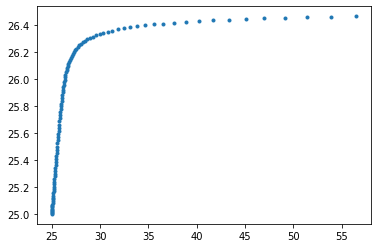

In [89]:
plt.plot(pos_arr[:,0],pos_arr[:,1],'.')

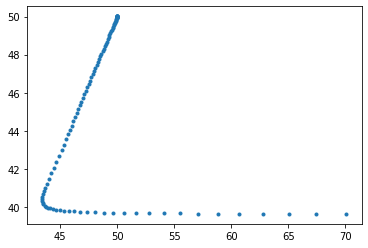

In [87]:
plt.plot(pos_arr[:,0],pos_arr[:,1],'.')

In [24]:
import scipy.integrate as integrate

def fried(y,t,H0,Om,OL):
    a = y
    dadt = a*H0*np.sqrt(Om/a**3+OL)
    return dadt

a0=0.0078125
H0=0.0003333
Om=0.25
OL=0.75
t=np.linspace(0,1.1*H0**(-1),1000)
sol = integrate.odeint(fried, a0, t, args=(H0,Om,OL))

In [29]:
from scipy import interpolate

f = interpolate.interp1d(t, sol[:,0])

In [44]:
time_Hubble_of_a(0.4059156900428647)

(1000.0000000000001, 0.0007061692205929987)

In [49]:
a_Hubble_of_t(1000)

(0.4059156900428647, 0.0007061692205929987)

In [33]:
f(3050)

array(1.00369523)

In [34]:
func = lambda tau : f(tau)-1.0
from scipy.optimize import fsolve
soln=fsolve(func,H0**(-1))

In [35]:
soln

array([3038.92608609])

In [37]:
t1=1000
a1=f(t1)
H1=(f(t1+0.001)-f(t1-0.001))/(0.002)/a1
print(t1,a1,H1)

1000 0.4059156900428647 0.0007061692205929987


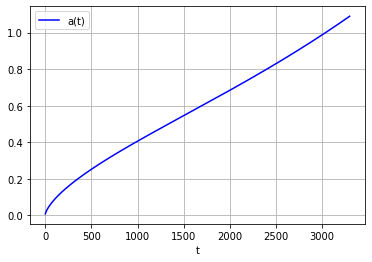

In [25]:
import matplotlib.pyplot as plt
plt.plot(t, sol[:, 0], 'b', label='a(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [3]:
#for particle type 1 (high resolution) only
path=cwd+'Sim_50/'
snaps,slnums,sl=grp.get_snapshot_info(path)
bchoice=100
xmin=0
xmax=100
ymin=0
ymax=100
zmin=0
zmax=100

si=4
rho,xc,yc,zc=grp.rho_of_snap_P1(path,slnums,snaps[si],xmin,xmax,ymin,ymax,zmin,zmax,bchoice)
redz,time=grp.get_z_t(path,snaps[si])

In [4]:
redz

5.407171022730776

In [18]:
time

0.15607512214865052

In [19]:
time**(-1)-1

5.407171022730776

In [10]:
rhok = ifftn(rho*4.78e-10*(1+redz)**3)
phix = fftn(rhokoverkm2(rhok))
dx=1
posx,posy,posz=46,46,46
-1/dx*(4*np.pi*(phix[posx+1,posy,posz]-phix[posx,posy,posz]))

(-1.8916984778438436e-06+2.7064065825613713e-22j)

In [12]:
np.real(Fg(rho,redz,46,46,46,1,1,1))

array([-1.70356243e-06, -3.29714639e-06, -1.24291544e-06])

In [15]:
np.real(Fgk2(rho,redz,46,46,46,1,1,1))

array([-1.70356243e-06, -3.29714639e-06, -1.24291544e-06])

In [16]:
np.real(Fg(rho,redz,46,46,46,1,1,1))

array([-1.73856330e-06, -3.25735343e-06, -1.26307085e-06])

In [ ]:
v=np.asarray([0.00006,0.00006,0.00006])*(1+redz)
p=np.asarray([xc[46],yc[46],zc[46]])
timestep()

In [107]:
rrkm2=rhokoverkm2(f)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in cdouble_scalars


In [109]:
rrkm2[99,99,99]

(0.005090702238112257+0.04789129701431525j)

In [79]:
f=ifftn(rho)

In [90]:
f[2,2,2]

(-0.0005490278110105579-0.00011816274611515891j)

In [42]:
rrkm2

In [13]:
snaps[0]

'000'

In [68]:
rho[44,38,45]

4.5588036419358104

In [21]:
f=fftn(rho)

In [69]:
f[44,38,45]

(-6.095620424464798+6.631200844247721j)

In [20]:
ifftn(f)[44,38,45]

(4.5588036419358104+1.482043346169039e-16j)

In [4]:
#for particle type 1 (high resolution) only
path=cwd+'Sim_100v/'
snaps,slnums,sl=grp.get_snapshot_info(path)
bchoice=100
xmin=0
xmax=100
ymin=0
ymax=100
zmin=0
zmax=100
#s=100.0

for i in range(len(snaps)):
    print('getting particles for snapshot '+snaps[i]+'.')
    t1=datetime.datetime.now()
    if i==0:
        t0=t1
    p,m=grp.get_particles_type(path,slnums,snaps[i],ptypes=['PartType1'])
#    m=np.asarray(m,dtype=np.float64)
    m=grp.lists_in_dict_to_array(m)
    p=grp.lists_in_dict_to_array(p)
    p={'x':p['xP1'],'y':p['yP1'],'z':p['zP1']}
    m=m['mP1']
    redz,time=grp.get_z_t(path,snaps[i])
    t2=datetime.datetime.now()
    print('took '+str((t2-t1).total_seconds())+' seconds.')
    x3,y3,z3,m3=p['x'],p['y'],p['z'],m
    print('getting rho for '+snaps[i]+'.')
    t1=datetime.datetime.now()
    rho,xc,yc,zc=grc.fastest_getrhoxyz_minmax(x3,y3,z3,m3,bchoice,xmin,xmax,ymin,ymax,zmin,zmax)
    t2=datetime.datetime.now()
    print('took '+str((t2-t1).total_seconds())+' seconds.')
    rhofilename='rho_100b_100vsn_0100/rhoP1_100_'+snaps[i]+'.txt'
    print('storing rho to file called \"'+rhofilename+'\"')
    t1=datetime.datetime.now()
    grp.rho_to_file_concise(xc,yc,zc,rho,snaps[i],snaps[-1],file_path=path,file_ns=rhofilename,redshift=str(redz),time=str(time))
    t2=datetime.datetime.now()
    print('took '+str((t2-t1).total_seconds())+' seconds.')
    if i == (len(snaps)-1):
        print('Full process took '+str(((t2-t0).total_seconds())/60)+' minutes.')

getting particles for snapshot 000.
took 4.892401 seconds.
getting rho for 000.
took 0.154675 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_000.txt"
took 0.551288 seconds.
getting particles for snapshot 001.
took 5.254925 seconds.
getting rho for 001.
took 0.147768 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_001.txt"
took 0.589717 seconds.
getting particles for snapshot 002.
took 4.466956 seconds.
getting rho for 002.
took 0.13841 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_002.txt"
took 0.566714 seconds.
getting particles for snapshot 003.
took 4.322358 seconds.
getting rho for 003.
took 0.153711 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_003.txt"
took 0.570251 seconds.
getting particles for snapshot 004.
took 3.953316 seconds.
getting rho for 004.
took 0.147856 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_004.txt"
took 0.570319 seconds.
getting particles for snapshot 

took 0.786724 seconds.
getting particles for snapshot 043.
took 4.47052 seconds.
getting rho for 043.
took 0.159219 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_043.txt"
took 0.85639 seconds.
getting particles for snapshot 044.
took 4.944117 seconds.
getting rho for 044.
took 0.223344 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_044.txt"
took 0.714345 seconds.
getting particles for snapshot 045.
took 4.773221 seconds.
getting rho for 045.
took 0.19702 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_045.txt"
took 0.615821 seconds.
getting particles for snapshot 046.
took 4.789366 seconds.
getting rho for 046.
took 0.150854 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_046.txt"
took 0.644342 seconds.
getting particles for snapshot 047.
took 4.809283 seconds.
getting rho for 047.
took 0.160406 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_047.txt"
took 0.624229 seconds.
getting pa

took 4.712918 seconds.
getting rho for 085.
took 0.167607 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_085.txt"
took 0.649452 seconds.
getting particles for snapshot 086.
took 4.355362 seconds.
getting rho for 086.
took 0.156223 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_086.txt"
took 0.585019 seconds.
getting particles for snapshot 087.
took 3.994294 seconds.
getting rho for 087.
took 0.172044 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_087.txt"
took 0.617718 seconds.
getting particles for snapshot 088.
took 4.626675 seconds.
getting rho for 088.
took 0.146769 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_088.txt"
took 0.601757 seconds.
getting particles for snapshot 089.
took 5.163409 seconds.
getting rho for 089.
took 0.151116 seconds.
storing rho to file called "rho_100b_100vsn_0100/rhoP1_100_089.txt"
took 0.60589 seconds.
getting particles for snapshot 090.
took 4.089779 seconds.
getting 